# Update for heterogeneous

Novozhilov takes the following as the PDF of a gamma distribution:

$$ p(\omega|\nu,k) = \frac{\nu^k}{\Gamma(k)} \omega^{k-1} \mathrm{e}^{-\nu \omega} \, . $$

The differential equations are then, by his Proposition 1 and Equation (19),

$$ \frac{\mathrm{d}S}{\mathrm{d}t} = - h(S) I \, , \qquad h(S) = \frac{kS}{\nu} \left(\frac{S}{S_0}\right)^{1/k} \, .$$

In simulations, we picked gamma random variables using

    distvar = 2.
    gd = scipy.stats.gamma(a=1./distvar, loc=0., scale=distvar)

The pdf here is

$$ f(x | a, \theta) = \frac{\theta^{-a} x^{a-1}\mathrm{e}^{-x /\theta}}{\Gamma(a)} \, , $$

where $\theta$ is the scale, equal to distvar, and a is 1/distvar, so comparing with the above we have

$$ h(S) = \frac{S/\theta}{1/\theta} \left(\frac{S}{S_0}\right)^{\theta} = \frac{S^{\theta + 1}}{S_0^{\theta}} \, .$$

Now, some care is needed here because in the Novozhilov paper $\beta$ is absorbed into other factors. In practice, we will take

$$ \frac{\mathrm{d}S}{\mathrm{d}t} = - \beta \frac{S^{1+\theta}}{N^{1+\theta}} I \, , $$

since this will produce the right $R_0$.


In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm


In [2]:
# Transmission Parameters - change values of beta and gamma for supplementary figures based on different 
# values of R0

beta = 2/7 # 3/7, 1.5/10
gamma = 1/7 # 1/7, 1/10 
Reff = beta/gamma # Effective reproduction number


omega = beta + gamma # Average lifetime of infectious case
r = beta - gamma # Growth rate 
rho = omega


ntime = 10000
Tmax = 1000
time = np.linspace(0, Tmax, ntime)
dtime = np.diff(time)[0]

# Initial conditions for probability of extinction and moment equations

q0 = 0
m0 = 1
m2_0 = 1

# Colour map

cmap = sns.color_palette("Set2")




Define offspring distribution for the branching process and then recover moments and probability of extinction, q(t), over time:

In [3]:
def Offspring(s):
    return 1/(omega) * ((beta * s**2) + gamma)

def q_deriv(u, t):
    return omega * (Offspring(u) - u)



u1 = omega*(1/omega * 2*beta - 1)

u2 = 2*beta 

def mean_deriv(u, t):
    return u1*u

def m2_deriv(u, t):
    return u2 * np.exp(2*u1*t) + u1 * u



q = sp.integrate.odeint(q_deriv, q0, time)

mean = (sp.integrate.odeint(mean_deriv, m0, time))

moment_2 = sp.integrate.odeint(m2_deriv, m2_0, time)

var = moment_2 - mean**2
q_grad = np.gradient(q.flatten(), dtime)
tstar_q = np.where(q_grad<=1e-3)[0][0]

var_coeff = np.sqrt(var)/(mean)
var_coeff_grad =  np.gradient(var_coeff.flatten(), dtime)
tstar_var_coeff = np.where(var_coeff_grad<=1e-3)[0][0]


/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21254/3445174604.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(time, np.log(var ), label = "Variance", color = cmap[2])


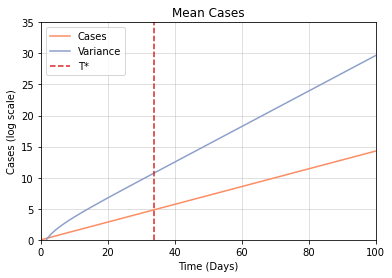

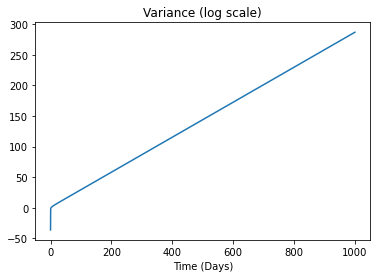

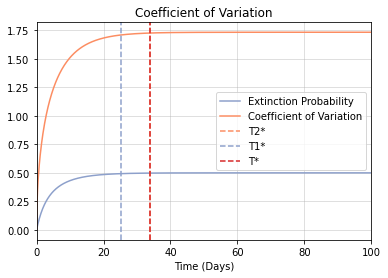

In [7]:

plt.figure(1)
plt.grid(alpha = 0.5)
plt.plot(time, np.log(mean), label = "Cases", color = cmap[1])
plt.plot(time, np.log(var ), label = "Variance", color = cmap[2])
plt.axvline(time[np.max((tstar_q, tstar_var_coeff))], color = 'tab:red', linestyle = '--', label = "T*")
plt.title("Mean Cases")
plt.xlim([0, 100])
plt.ylim([0, 35])
plt.xlabel("Time (Days)")
plt.ylabel("Cases (log scale)")
plt.legend()
# plt.savefig("mean_var_R=" + str(int(Reff)) + ".pdf")



plt.figure(2)
plt.plot(time, np.log(var + np.finfo(float).eps))
plt.title("Variance (log scale)")
plt.xlabel("Time (Days)")



plt.figure(3)
plt.plot(time, q, label = "Extinction Probability", color = cmap[2])
plt.plot(time, var_coeff, label = "Coefficient of Variation", color = cmap[1])
plt.grid(alpha = 0.5)
plt.axvline(time[tstar_var_coeff], color = cmap[1], linestyle = '--', label = "T2*")
plt.axvline(time[tstar_q], color = cmap[2], linestyle = '--', label = "T1*")
plt.axvline(time[np.max((tstar_q, tstar_var_coeff))] , color = 'tab:red', linestyle = '--', label = "T*")
plt.title("Coefficient of Variation")
plt.xlabel("Time (Days)")
plt.xlim([0, 100])
plt.legend()
plt.savefig("Tstar_choice_R=" + str(int(Reff)) + ".pdf")

Define $T^*$ and, hence, $Z^*$ based on different values of $\epsilon$ for the extinction probability and coefficient of variation:

In [4]:
u1 = beta - gamma
omega = beta + gamma



epsilons = 1e-5 * np.array((0.5e4, 1e3, 0.5e3, 1e2, 0.5e2, 1e1, 0.5e1, 1, 0.5))
tstar_qs_list = [np.where(q_grad<=thresh)[0][0] for thresh in epsilons]
tstar_qs = np.array(tstar_qs_list)
tstar_var_coeffs_list = [np.where(var_coeff_grad<=thresh)[0][0] for thresh in epsilons]
tstar_var_coeffs = np.array(tstar_var_coeffs_list)
tstar_idxs = np.maximum(tstar_qs, tstar_var_coeffs)


stop_cases = mean[tstar_idxs]#/q[tstar_idxs]
stop_cases_sqrt = [np.sqrt(im) for im in stop_cases]
cols = [str(int(label)) for label in stop_cases]
cols_sqrt = [str(int(label)) for label in stop_cases_sqrt]


stop_cases_idx = 3 # Index corresponding to baseline \epsilon = 10^{-3}
st_idx = stop_cases_idx
tstar_idx = tstar_idxs[stop_cases_idx]
Imax_feller = stop_cases[stop_cases_idx][0]
Imax = np.sqrt(Imax_feller)

In [5]:
Imax_feller # Z^* for baseline \epsilon= 10^{-3}

125.09261928186953

Simualte the Feller diffusion using the Euler-Maruyama method:

In [7]:

def gp_mu(u, t):
    return (u1)/2 * u

def gp_sigma(u, t):
    return np.sqrt(omega)/2

def gp_var(u, t):
    return (u1)*u + (omega/4)

def dW(t):
    return np.random.normal(loc = 0.0, scale = np.sqrt(t))


# Unapproximated Feller Diffusion

def feller_mu(u, t):
    return (beta - gamma) * u 

def feller_sigma(u, t):
    return np.sqrt(omega * u)

def feller_sigma_theory(u, t):
    return 2*u1*u + omega


def EulerMaruyama(drift, sigma, dW, t0, y0, dt, stop = None, num_its = len(time)):
    t = t0
    y = np.zeros(num_its)
    y[0] = y0
    stop_times = []
    checks = 0
    for i in range(1, num_its):
        yn = y[i-1] + drift(y[i-1], t)*dt + sigma(y[i-1],t) * dW(dt)
        if yn >0:
            y[i] = yn
        else:
            y[i] = 0
            stop_times = [np.nan for i in range(len(stop))]
            break
        
        if stop is not None:
            if yn >= stop[checks]:
                y[i:] = yn
                stop_time = t - dt
                stop_times.append(stop_time)
                checks +=1
                if checks == len(stop):
                    break
            
            
        
        t += dt
    if stop is not None:       
        if len(stop_times)<len(stop):
            stop_times_append = len(stop) - len(stop_times)
            stop_times_nans = [np.nan for i in range(stop_times_append)]
            stop_times += stop_times_nans
        
    return stop_times, y




y0 = 1
t0 = 0
dt = np.diff(time)[0]


nsims = 100000
np.random.seed(123)
# stop_times = np.zeros((nsims, len(stop_cases)))
# stop_times1 = np.zeros((nsims, len(stop_cases)))
# for i in tqdm(range(nsims)):
#     stop_time, feller_sim = EulerMaruyama(gp_mu, gp_sigma, dW, t0, y0, dt, stop = stop_cases_sqrt, num_its = len(time))
#     stop_times[i, :] = stop_time
#     stop_time1, feller_sim1 = EulerMaruyama(feller_mu, feller_sigma, dW, t0, y0, dt, stop = stop_cases, num_its = len(time))
#     stop_times1[i, :] = stop_time1
#     if i%(int(nsims/10)) == 0:
# #         plt.plot(time, feller_sim, alpha = 0.8)
    
# stop_times_df = pd.DataFrame(stop_times, columns = cols_sqrt)
# # stop_times_df = stop_times_df[stop_times_df["T*"] != 0]
 
# stop_times_df1 = pd.DataFrame(stop_times1, columns = cols)
# # stop_times_df1 = stop_times_df1[stop_times_df1["T*"] != 0]





In [11]:
def diff_LNA1(u, t):
    return np.sqrt(omega)* np.exp(r*t/2)

def diff_LNA2(u, t):
    y = u -np.exp(r*t)
    return np.sqrt(omega) * (np.exp(r*t/2) - (1/2 * np.exp(-r*t/2)*y))



nsims = 100000
np.random.seed(123)
stop_times_LNA1 = np.zeros((nsims, len(stop_cases)))
stop_times_LNA2 = np.zeros((nsims, len(stop_cases)))
for i in tqdm(range(nsims)):
    stop_time_LNA1, feller_sim = EulerMaruyama(feller_mu, diff_LNA1, dW, t0, y0, dt, stop = stop_cases, num_its = len(time))
    stop_times_LNA1[i, :] = stop_time_LNA1
    stop_time_LNA2, feller_sim1 = EulerMaruyama(feller_mu, diff_LNA2, dW, t0, y0, dt, stop = stop_cases, num_its = len(time))
    stop_times_LNA2[i, :] = stop_time_LNA2

stop_times_LNA1_df = pd.DataFrame(stop_times_LNA1, columns = cols)
stop_times_LNA2_df = pd.DataFrame(stop_times_LNA2, columns = cols)




100%|██████████████████████████████████| 100000/100000 [11:46<00:00, 141.46it/s]


In [12]:

def gillespie(beta, gamma, y0, Tmax = Tmax, nevents = int(1e6), stop = [Imax_feller]):
    omega = beta + gamma
    t = 0
    rands = np.random.random(2*nevents).reshape((nevents, 2))
    cases = np.nan * np.ones(nevents)
    cases[0] = y0
    checks = 0
    stop_times = []
    for e in range(1, nevents):
        rate_vec = np.array((beta*cases[e-1], gamma*cases[e-1]))
        rate_sum = np.sum(rate_vec)

        rate_cumsum = np.cumsum(rate_vec)
        dt = -np.log(rands[e, 0])/rate_sum
        t += dt
        event_rand = rate_sum * rands[e, 1]
        event = np.where(rate_cumsum > event_rand)[0][0]
        if event ==0:
            cases[e] = cases[e-1] + 1
        elif event == 1:
            cases[e] = cases[e-1] - 1
        if cases[e] >= stop[checks]:
            cases[(e+1):] = cases[e]
            stop_times.append(t)
            checks +=1
            if checks == len(stop):
                break
        elif cases[e] == 0:
            stop_times = [np.nan for i in range(len(stop))]
            cases[(e+1):] = 0
            break
    if len(stop_times)<len(stop):
        stop_times_append = len(stop) - len(stop_times)
        stop_times_nans = [np.nan for i in range(stop_times_append)]
        stop_times += stop_times_nans
    return stop_times, cases
nsims = 100000
stop_times2 = np.zeros((nsims, len(stop_cases)))
np.random.seed(123)
for i in tqdm(range(nsims)):
    stop_time2, gillespie_sim = gillespie(beta, gamma, 1, stop = stop_cases)
    stop_times2[i, :] = stop_time2
        
        

stop_times_df2  = pd.DataFrame(stop_times2, columns = cols)
stop_times_df2[cols] = stop_times_df2[cols].replace({0:np.nan})
stop_times_df2


100%|████████████████████████████████| 100000/100000 [11:27:04<00:00,  2.43it/s]


,3,12,25,125,248,1247,2477,12450,24718
0,9.700666,13.214517,19.574329,32.926367,38.739487,49.376981,54.243323,65.558041,70.222713
1,4.680675,27.006573,34.330972,44.467297,48.315943,59.304824,63.922072,75.278126,80.096696
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7.321535,13.274254,20.009836,32.350223,37.343939,47.700160,52.733269,63.996354,68.801481
...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
stop_times_df2.to_csv("stop_times_df2.csv", index = False)

In [11]:
stop_times_df2 = pd.read_csv("stop_times_df2.csv")
stop_times_df2

,3,12,25,125,248,1247,2477,12450,24718
0,9.700666,13.214517,19.574329,32.926367,38.739487,49.376981,54.243323,65.558041,70.222713
1,4.680675,27.006573,34.330972,44.467297,48.315943,59.304824,63.922072,75.278126,80.096696
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7.321535,13.274254,20.009836,32.350223,37.343939,47.700160,52.733269,63.996354,68.801481
...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


  0%|                                                 | 0/10000 [00:00<?, ?it/s]/Users/jakeyc-s/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 774.77it/s]


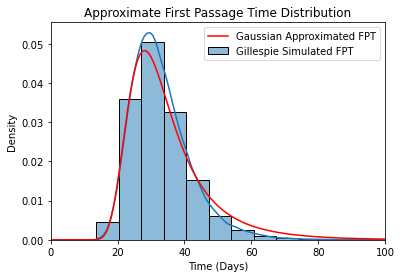

In [12]:
dtime = time[1] - time[0]
st_idx = 3
sns.color_palette("Accent")
gp_mean_theory = sp.integrate.odeint(gp_mu, y0, time)
gp_var_theory = sp.integrate.odeint(gp_var, 0, time)
cdf = np.zeros_like(time)
for t_idx in tqdm(range(len(time))):
    prob = (1 - sp.stats.norm(gp_mean_theory[t_idx], (gp_var_theory[t_idx])**(1/2)).cdf(stop_cases_sqrt[st_idx]))/(1-sp.stats.norm(gp_mean_theory[t_idx], (gp_var_theory[t_idx])**(1/2)).cdf(0))
    cdf[t_idx] = prob

pdf = np.gradient(cdf, dtime)
pdf[np.isnan(pdf)] = 0
plt.figure(1)
sns.histplot(stop_times_df2[cols[st_idx]], stat = 'density', bins = 20, label = "Gillespie Simulated FPT", kde = True)
plt.plot(time, pdf, color = 'r', label = "Gaussian Approximated FPT")
plt.xlabel("Time (Days)")
plt.xlim([0, 100])
plt.title("Approximate First Passage Time Distribution")
plt.legend()

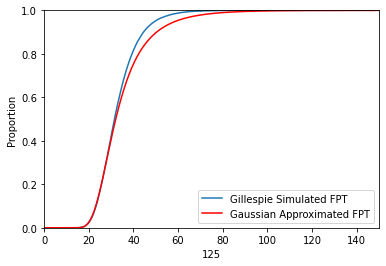

In [13]:
new_cdf = cdf
ecdf_df = stop_times_df2[cols[st_idx]].dropna()
sns.ecdfplot(ecdf_df, label = "Gillespie Simulated FPT")
plt.plot(time, new_cdf, color = 'r', label = "Gaussian Approximated FPT")
ecdf2 = np.zeros_like(time)
for t_idx, T in enumerate(time):
    ecdf2[t_idx] = len(np.where(ecdf_df <= T)[0])/len(ecdf_df)    
plt.xlim([0, 150])
plt.legend()


In [14]:

median_idx = np.min(np.where(new_cdf >= 0.5)[0])
uq_idx = np.min(np.where(new_cdf >= 0.975)[0])
lq_idx = np.min(np.where(new_cdf >= 0.025)[0])

t_mean = time[tstar_idx]
t_med = time[median_idx]
t_uq = time[uq_idx]
t_lq = time[lq_idx]
t_iqr = t_uq - t_lq

Peak at 78.1 days


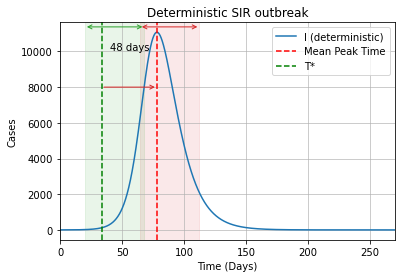

In [49]:
N = 1e5
I0 = Imax_feller
S0 = N-I0
R0 = 0
Reff = beta/gamma
inits = np.array((S0, I0, R0))

# NOTE SET theta TO DISTVAR FROM SIMULATIONS
theta = 1/2.
def sir_nov(u, t):
    deriv = np.zeros(3)
    deriv[0] = -beta*u[1]*((u[0]/N)**(theta+1.))
    deriv[1] = beta*u[1]*((u[0]/N)**(theta+1.)) - gamma*u[1]
    deriv[2] = gamma*u[1]
    return deriv



sir_curves = sp.integrate.odeint(sir_nov, inits, time)

I_curve = sir_curves[:, 1]
plt.plot(time + t_mean, I_curve, label = "I (deterministic)", color = "tab:blue" )
plt.plot(time[:tstar_idx], mean[:tstar_idx], color = "tab:blue")
plt.xlim([0, 270])
peak = np.max(I_curve)
peak_idx = np.argmax(I_curve)
# peak_idx = np.where(I_curve == np.max(I_curve))[0][0]
peak_time = time[peak_idx]
arrow_text = str(int(t_iqr)) + ' days'


# plt.arrow(t_lq + peak_time, peak+0.1, t_iqr, 0, width = 1, length_includes_head = True, color = 'y')
above = 0.03 * N/10
plt.annotate(text='', xy=(t_lq + peak_time,peak+above), xytext=(t_uq+peak_time,peak+above), arrowprops=dict(color = 'tab:red', arrowstyle='<->'))
plt.annotate(text='', xy=(t_lq,peak+above), xytext=(t_uq,peak+above), arrowprops=dict(color = 'tab:green', arrowstyle='<->'))
plt.text(40, peak - N/100, arrow_text)

plt.axvspan(t_lq + peak_time, t_uq+peak_time, alpha=0.1, color='tab:red')
plt.axvspan(t_lq, t_uq, alpha=0.1, color='tab:green')

plt.axvline(t_mean + peak_time, linestyle = '--', color = 'red', label = "Mean Peak Time")
plt.axvline(t_mean, linestyle = '--', color = 'green', label = "T*")
plt.annotate(text='', xy=(t_mean, 0.8 * N/10), xytext=(t_mean+peak_time, 0.8 * N/10), arrowprops=dict(color = 'tab:red', arrowstyle='<-', linestyle = "-"))



plt.title("Deterministic SIR outbreak")
plt.grid(alpha = 0.8)
plt.xlabel("Time (Days)")
plt.ylabel("Cases")

plt.legend()

# plt.savefig("SIR_delay_gp_R=" + str(int(Reff)) + ".pdf")
print("Peak at " + str(np.round(t_mean+peak_time, 1)) + " days")

Peak at 78.3078307830783 days


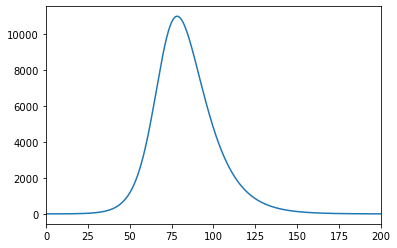

In [51]:
inits1 = np.array((N-1, 1, R0))
sir_curves1 = sp.integrate.odeint(sir_nov, inits1, time)
I_curve1 = sir_curves1[:, 1]
plt.plot(time, I_curve1)
plt.xlim([0, 200])
print("Peak at " + str(time[np.argmax(I_curve1)]) + " days")

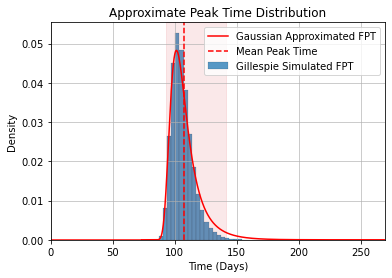

In [17]:
plt.plot(time +peak_time, pdf, color = 'r', label = "Gaussian Approximated FPT")
sns.histplot(stop_times_df2[cols[st_idx]]+ peak_time, stat = 'density', bins = 40, label = "Gillespie Simulated FPT")
plt.axvspan(t_lq + peak_time, t_uq+peak_time, alpha=0.1, color='tab:red')
plt.axvline(t_mean + peak_time, linestyle = '--', color = 'red', label = "Mean Peak Time")
plt.plot(time[:peak_idx], np.zeros(peak_idx), color = 'r')
plt.grid(alpha = 0.8)
plt.title("Approximate Peak Time Distribution")
plt.xlabel("Time (Days)")
plt.xlim([0, 270])
plt.legend()
plt.savefig("Peak_time_dist_gp_R=" + str(int(Reff)) + ".pdf")


In [19]:
np.mean(stop_times_df2[cols[st_idx]].dropna()) - t_mean

nsims = 1000
stop_times_bp = np.zeros((nsims, len(stop_cases)))
np.random.seed(123)
for i in tqdm(range(nsims)):
    stop_time_bp, gillespie_sim = gillespie(beta, gamma, 1, stop = stop_cases)
    stop_times_bp[i, :] = stop_time_bp
stop_times_df_bp  = pd.DataFrame(stop_times_bp, columns = cols)
stop_times_df_bp[cols] = stop_times_df_bp[cols].replace({0:np.nan})
stop_times_df_bp


100%|███████████████████████████████████████| 1000/1000 [06:37<00:00,  2.52it/s]


,3,12,25,125,248,1247,2477,12450,24718
0,9.700666,13.214517,19.574329,32.926367,38.739487,49.376981,54.243323,65.558041,70.222713
1,4.680675,27.006573,34.330972,44.467297,48.315943,59.304824,63.922072,75.278126,80.096696
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7.321535,13.274254,20.009836,32.350223,37.343939,47.700160,52.733269,63.996354,68.801481
...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,6.395712,8.504227,15.101758,24.230487,28.219070,39.959085,44.638490,55.970637,60.716171
998,5.541643,9.136240,11.827855,19.932645,24.395146,35.217745,40.066381,51.563450,56.501513


  0%|                                                 | 0/10000 [00:00<?, ?it/s]/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_33270/3751302904.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  x_scale = 2*r*x/(((rho/2))*(np.exp(r*t) - 1))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_33270/3751302904.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  lamb = 2*r*np.exp(r*t)/((rho/2)*(np.exp(r*t) - 1))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_33270/3751302904.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  chi_sq_pdf = r/((rho/2)*(np.exp(r*t) - 1)) * np.sqrt(np.exp(r*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_33270/3751302904.py:10: RuntimeWarning: invalid value encountered in double_scalars
  chi_sq_pdf = r/((rho/2)*(np.exp(r*t) - 1)) * np.sqrt(np.exp(r*t)/x) * np.

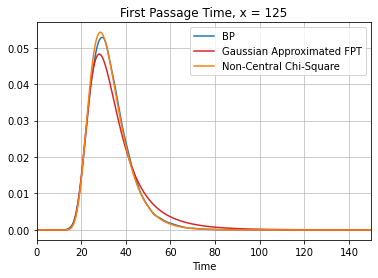

In [36]:
r = beta - gamma
rho = beta + gamma

gp_mean_theory = sp.integrate.odeint(gp_mu, y0, time)
gp_var_theory = sp.integrate.odeint(gp_var, 0, time)

def chi_sq(u, x, t):
    x_scale = 2*r*x/(((rho/2))*(np.exp(r*t) - 1))
    lamb = 2*r*np.exp(r*t)/((rho/2)*(np.exp(r*t) - 1))
    chi_sq_pdf = r/((rho/2)*(np.exp(r*t) - 1)) * np.sqrt(np.exp(r*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))

    return chi_sq_pdf

# kde_feller = sp.stats.gaussian_kde(stop_times_df1[cols[st_idx]].dropna().to_numpy().flatten())
# kde_feller_sqrt = sp.stats.gaussian_kde(stop_times_df[cols_sqrt[st_idx]].dropna().to_numpy().flatten())
kde_bp = sp.stats.gaussian_kde(stop_times_df2[cols[st_idx]].dropna().to_numpy().flatten())
# kde_bp_approx = sp.stats.gaussian_kde(stop_times_df_bp[cols[st_idx]].dropna().to_numpy().flatten())

xvec = np.linspace(np.finfo(float).eps, 20000, int(1e5))
xvec_idx = np.min(np.where(xvec>=stop_cases[st_idx])[0])

cdf_chisq = np.zeros_like(time)
cdf_gp = np.zeros_like(time)

for T_idx in tqdm(range(len(time))):
    T = time[T_idx]
    
    chi_sq_integral = sp.integrate.odeint(chi_sq, 0, xvec, args = (T,)).flatten() 

    prob =  (1-(chi_sq_integral[xvec_idx]))
    cdf_chisq[T_idx] = prob
    prob_gp = (1 - sp.stats.norm(gp_mean_theory[T_idx], (gp_var_theory[T_idx])**(1/2)).cdf(stop_cases_sqrt[st_idx]))/(1-sp.stats.norm(gp_mean_theory[T_idx], (gp_var_theory[T_idx])**(1/2)).cdf(0))
    cdf_gp[T_idx] = prob_gp
    
pdf_gp = np.gradient(cdf_gp, dtime)
pdf_chisq = np.gradient(cdf_chisq, dtime)






plt.figure()
# sns.histplot(stop_times_df2[cols[st_idx]], stat = "density", kde = True, label = "BP")




# plt.plot(time, kde_feller_sqrt(time), label = "Feller_sqrt", color = cmap[5])
# plt.plot(time, kde_feller(time), label = "Feller", color = cmap[4])
plt.plot(time, kde_bp(time), color = "tab:blue", label = "BP")
plt.plot(time, pdf_gp, color = "tab:red", label = "Gaussian Approximated FPT")
plt.plot(time, pdf_chisq, label = "Non-Central Chi-Square", color = "tab:orange")
plt.xlabel("Time")
plt.grid(alpha = 0.8)
plt.title("First Passage Time, x = " + cols[st_idx])
kde_bp_test = kde_bp(time)
# print(time[np.where(kde_bp_test == np.max(kde_bp_test))[0][0]] - time[np.where(pdf_chisq == np.max(np.nan_to_num(pdf_chisq)))[0][0]])
# print(np.where(pdf_chisq == np.max(np.nan_to_num(pdf_chisq)))[0])

plt.xlim([0, 150])
plt.legend()

Peak at 42.2 days


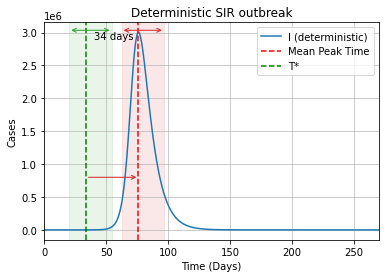

In [40]:
median_idx_chisq = np.min(np.where(cdf_chisq >= 0.5)[0])
uq_idx_chisq = np.min(np.where(cdf_chisq >= 0.975)[0])
lq_idx_chisq = np.min(np.where(cdf_chisq >= 0.025)[0])

t_mean = time[tstar_idx]
t_med_chisq = time[median_idx_chisq]
t_uq_chisq = time[uq_idx_chisq]
t_lq_chisq = time[lq_idx_chisq]
t_iqr_chisq = t_uq_chisq - t_lq_chisq


sir_curves = sp.integrate.odeint(sir_nov, inits, time)
I_curve = sir_curves[:, 1]
plt.plot(time + t_mean, I_curve, label = "I (deterministic)", color = "tab:blue" )
plt.plot(time[:tstar_idx], mean[:tstar_idx], color = "tab:blue")
plt.xlim([0, 270])
peak = np.max(I_curve)
peak_idx = np.where(I_curve == np.max(I_curve))[0][0]
peak_time = time[peak_idx]
arrow_text = str(int(t_iqr_chisq)) + ' days'

# plt.arrow(t_lq + peak_time, peak+0.1, t_iqr, 0, width = 1, length_includes_head = True, color = 'y')
above = 0.03 * N/10
plt.annotate(text='', xy=(t_lq_chisq + peak_time,peak+above), xytext=(t_uq_chisq+peak_time,peak+above), arrowprops=dict(color = 'tab:red', arrowstyle='<->'))
plt.annotate(text='', xy=(t_lq_chisq,peak+above), xytext=(t_uq_chisq,peak+above), arrowprops=dict(color = 'tab:green', arrowstyle='<->'))
plt.text(40, peak - N/100, arrow_text)

plt.axvspan(t_lq_chisq + peak_time, t_uq_chisq+peak_time, alpha=0.1, color='tab:red')
plt.axvspan(t_lq_chisq, t_uq_chisq, alpha=0.1, color='tab:green')

plt.axvline(t_mean + peak_time, linestyle = '--', color = 'red', label = "Mean Peak Time")
plt.axvline(t_mean, linestyle = '--', color = 'green', label = "T*")
plt.annotate(text='', xy=(t_iqr_chisq, 0.8 * N/10), xytext=(t_mean+peak_time, 0.8 * N/10), arrowprops=dict(color = 'tab:red', arrowstyle='<-', linestyle = "-"))



plt.title("Deterministic SIR outbreak")
plt.grid(alpha = 0.8)
plt.xlabel("Time (Days)")
plt.ylabel("Cases")

plt.legend()
plt.savefig("SIR_delay_chisq_R=" + str(int(Reff)) + "_Novozhilov.pdf")
print("Peak at " + str(np.round(t_mean + peak_time, 1)) + " days")

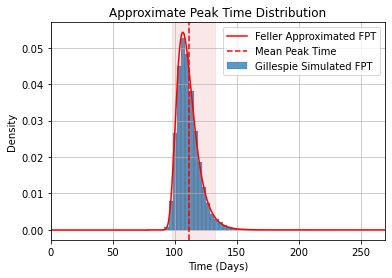

In [24]:
plt.plot(time +peak_time, pdf_chisq, color = 'r', label = "Feller Approximated FPT")
sns.histplot(stop_times_df2[cols[st_idx]]+ peak_time, stat = 'density', bins = 40, label = "Gillespie Simulated FPT")
plt.axvspan(t_lq_chisq + peak_time, t_uq_chisq+peak_time, alpha=0.1, color='tab:red')
plt.axvline(t_mean + peak_time, linestyle = '--', color = 'red', label = "Mean Peak Time")
plt.plot(time[:peak_idx], np.zeros(peak_idx), color = 'r')
plt.grid(alpha = 0.8)
plt.title("Approximate Peak Time Distribution")
plt.xlabel("Time (Days)")
plt.xlim([0, 270])
plt.legend()
plt.savefig("Peak_time_dist_chisq_R=" + str(int(Reff)) + ".pdf")




  0%|                                                 | 0/10000 [00:00<?, ?it/s]/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21254/2562243900.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  chi0 = np.exp(-(r*np.exp(r*T)/(rho*(np.exp(r*T) - 1))))
/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21254/3993158654.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  x_scale = 2*r*x/(((rho/2))*(np.exp(r*t) - 1))
/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21254/3993158654.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  lamb = 2*r*np.exp(r*t)/((rho/2)*(np.exp(r*t) - 1))
/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21254/3993158654.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  chi_sq_pdf = r/((rho/2)*(np.exp(r*t) - 1)) * np.sqrt(np.exp(r*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))
/var/folders/79/

(0.0, 100.0)

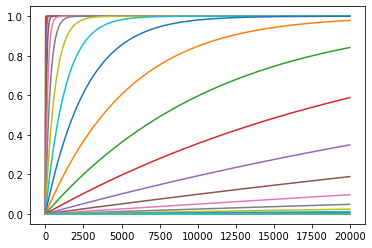

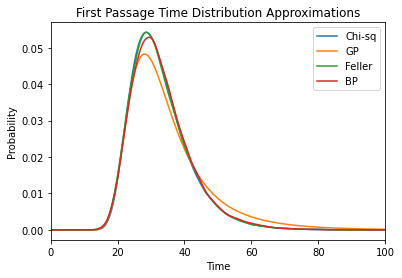

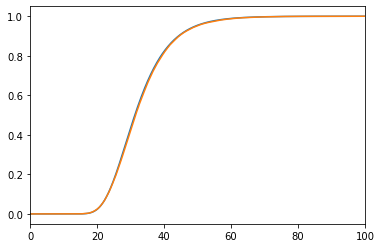

In [25]:
rho = beta + gamma
r = beta - gamma
xvec = np.linspace(np.finfo(float).eps, 20000, int(1e5))



xvec_idx = np.min(np.where(xvec>=stop_cases[st_idx])[0]) 

cdf_gp = np.zeros_like(time)
for T_idx in tqdm(range(len(time))):
    T = time[T_idx]
    chi0 = np.exp(-(r*np.exp(r*T)/(rho*(np.exp(r*T) - 1))))
    if T != 0:
        scaling = (2*r) / (rho*(np.exp(r*T) - 1)) 
        xvec_scale = xvec * 2*r / (rho*(np.exp(r*T) - 1))
        Imax_scale = Imax_feller / scaling
    else:
        xvec_scale = xvec
        Imax_scale = Imax_feller
    xvec_scale_idx = np.min(np.where(xvec>=Imax_feller)[0]) 
#     print(xvec_scale)
    chi_sq_integral = sp.integrate.odeint(chi_sq, 0, xvec, args = (T,)).flatten()
#     chi_sq_integral = (chi_sq_int(xvec, T) - chi0)/(1-chi0)
    if T_idx % int(len(time)/200) == 0:
        plt.figure(1)
        
        plt.plot(xvec, chi_sq_integral)
#         plt.ylim([0, 1])
        
    prob =  1-(chi_sq_integral[xvec_idx])
#     print(1-chi_sq_integral[xvec_idx])
    cdf_chisq[T_idx] = prob
    prob_gp = (1 - sp.stats.norm(gp_mean_theory[T_idx], (gp_var_theory[T_idx])**(1/2)).cdf(stop_cases_sqrt[st_idx]))/(1-sp.stats.norm(gp_mean_theory[T_idx], (gp_var_theory[T_idx])**(1/2)).cdf(0))
    cdf_gp[T_idx] = prob_gp
pdf_gp = np.gradient(cdf_gp, dtime)
pdf_chisq = np.gradient(cdf_chisq, dtime)
# for T_idx, T in enumerate(time):
#     chi0 = np.exp(-r*np.exp(r*T)/(rho*(np.exp(r*T) - 1)))
#     pdf_chisq[T_idx] = pdf_chisq[T_idx] /(1-chi0)
# plt.figure(30)
# # test = sp.integrate.odeint(chi_sq, 0, xvec, args = (time[50],)).flatten()
# chi50 = np.exp(-r*np.exp(r*time[50])/(rho*(np.exp(r*time[50]) - 1)))
# # print(chi_sq(10, xvec, time[50])/(1-chi50))
# # xvec_scale50 = 2*r*xvec/(rho*(np.exp(r*time[50]) - 1))
# plt.plot(xvec, chi_sq(10, xvec, time[50]), color = "tab:red")
# sns.histplot(check_cases_feller_df['50'], stat = 'density')

# plt.xlim([0, 60])
# plt.plot(xvec,test)
plt.figure(31)
plt.plot(time, pdf_chisq, label = "Chi-sq")
plt.plot(time, pdf_gp, label = "GP")
kde_bp = sp.stats.gaussian_kde(stop_times_df2[cols[st_idx]].dropna().to_numpy().flatten())
plt.plot(time, kde_feller(time), label = "Feller")
plt.plot(time, kde_bp(time), label = "BP")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Probability")
plt.xlim([0, 100])
plt.title("First Passage Time Distribution Approximations")
# plt.savefig("FPTs_R=" + str(Reff) + ".pdf")
# plt.plot(xvec, chi_sq(10, xvec, 10))

# chi_sq(1, xvec, 100)
plt.figure()
plt.plot(time, cdf_chisq)
plt.plot(time, ecdf2)
plt.xlim([0, 100])



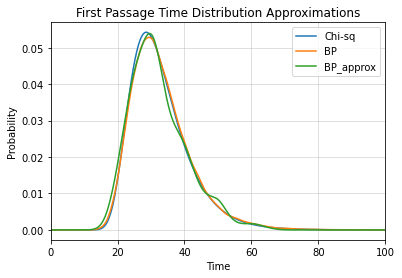

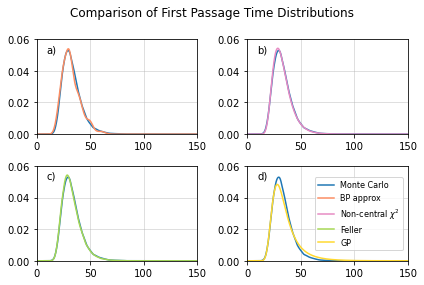

In [26]:
plt.figure(31)
import matplotlib.transforms as mtransforms
plt.plot(time, pdf_chisq, label = "Chi-sq")
plt.grid(alpha=0.5)
# plt.plot(time[:100], pdf_gp[:100], label = "GP")
kde_bp = sp.stats.gaussian_kde(stop_times_df2[cols[st_idx]].dropna().to_numpy().flatten())
kde_bp_plot =  kde_bp(time)
kde_feller_plot = kde_feller(time)
kde_bp_approx_plot = kde_bp_approx(time)
# plt.plot(time[:100], kde_feller(time[:100]), label = "Feller")
plt.plot(time, kde_bp(time), label = "BP")
plt.plot(time, kde_bp_approx(time), label = "BP_approx")
plt.xlim([0, 100])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Probability")
plt.title("First Passage Time Distribution Approximations")
# plt.savefig("FPTs_R=" + str(Reff) + ".pdf")

fig, ax = plt.subplots(2, 2)
trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
ax[0, 0].plot(time, kde_bp_plot, label = "Monte Carlo")
ax[0, 0].plot(time, kde_bp_approx_plot, label = "BP approx", color = cmap[1])
ax[0, 0].grid(alpha = 0.5)
ax[0, 0].text(0.0, 1.0, "a)", transform=ax[0, 0].transAxes + trans,
            fontsize='medium', verticalalignment='top')
ax[0, 0].set_xlim([0, 150])
ax[0, 0].set_ylim([0, 0.06])

ax[0, 1].plot(time, kde_bp_plot)
ax[0, 1].plot(time, pdf_chisq, label = "Non-central " + r'$\chi^2$', color = cmap[3])
ax[0, 1].grid(alpha = 0.5)
ax[0, 1].text(0.0, 1.0, "b)", transform=ax[0, 1].transAxes + trans,
            fontsize='medium', verticalalignment='top')
ax[0, 1].set_xlim([0, 150])
ax[0, 1].set_ylim([0, 0.06])

ax[1, 0].plot(time, kde_bp_plot)
ax[1, 0].plot(time, kde_feller_plot, label = "Feller", color = cmap[4])
ax[1, 0].grid(alpha = 0.5)
ax[1, 0].text(0.0, 1.0, "c)", transform=ax[1, 0].transAxes + trans,
            fontsize='medium', verticalalignment='top')
ax[1, 0].set_xlim([0, 150])
ax[1, 0].set_ylim([0, 0.06])


ax[1, 1].plot(time, kde_bp_plot)
ax[1, 1].plot(time, pdf_gp, label = "GP", color = cmap[5])
ax[1, 1].grid(alpha = 0.5)
ax[1, 1].text(0.0, 1.0, "d)", transform=ax[1, 1].transAxes + trans,
            fontsize='medium', verticalalignment='top')
ax[1, 1].set_xlim([0, 150])
ax[1, 1].set_ylim([0, 0.06])




fig.legend(bbox_to_anchor = (0.95, 0.4), prop={'size': 8})
plt.suptitle("Comparison of First Passage Time Distributions")
plt.tight_layout()

plt.savefig("FPT_comparison2_R=" + str(int(Reff)) + ".pdf")





In [27]:
def SSE(x, y):
    return np.sqrt(np.sum((x-y)**2))

xvec = np.linspace(np.finfo(float).eps, 60000, int(1e5))
convergence_mat = np.zeros((len(stop_cases), 3, 6))
eps = np.finfo(float).eps
for st in range(len(stop_cases)):
    st_df = stop_times_df2[cols[st]].dropna()
#     st_df_bp = stop_times_df_bp[cols[st]].dropna()
    st_df_LNA1 = stop_times_LNA1_df[cols[st]].dropna()
    st_df_LNA2 = stop_times_LNA2_df[cols[st]].dropna()
    st_df_feller = stop_times_df1[cols[st]].dropna()
    
    ecdf2 = np.zeros_like(time)
    ecdf_bp = np.zeros_like(time)
    ecdf_LNA1 = np.zeros_like(time)
    ecdf_LNA2 = np.zeros_like(time)

    ecdf_feller = np.zeros_like(time)
    xvec_idx = np.min(np.where(xvec>=stop_cases[st])[0]) 
    for t_idx in tqdm(range(len(time))):
        T = time[t_idx]
        chi_sq_integral = sp.integrate.odeint(chi_sq, 0, xvec, args = (T,)).flatten()
#         ecdf_bp[t_idx] = len(np.where(st_df_bp <= T)[0])/len(st_df_bp)
        ecdf_LNA1[t_idx] = len(np.where(st_df_LNA1 <= T)[0])/len(st_df_LNA1)
        ecdf_LNA2[t_idx] = len(np.where(st_df_LNA2 <= T)[0])/len(st_df_LNA2)
       
        ecdf2[t_idx] = len(np.where(st_df <= T)[0])/len(st_df)
        ecdf_feller[t_idx] = len(np.where(st_df_feller <= T)[0])/len(st_df_feller)
        prob =( 1 - sp.stats.norm(gp_mean_theory[t_idx], (gp_var_theory[t_idx])**(1/2)).cdf(stop_cases_sqrt[st]))/(1-sp.stats.norm(gp_mean_theory[t_idx], (gp_var_theory[t_idx])**(1/2)).cdf(0))
        cdf[t_idx] = prob
        prob_chisq =  1-(chi_sq_integral[xvec_idx])
        cdf_chisq[t_idx] = prob_chisq
    cdf_chisq[cdf_chisq<0] = 0
#     plt.plot(time, new_cdf, label = "GP")
#     plt.plot(time, ecdf2)
#     plt.plot(time, cdf_chisq, label = 'chisq')
#     plt.xlim([0, 100])
#     plt.legend()
    
    convergence_mat[st, 0, 0] = np.max(np.abs(ecdf2 - ecdf_bp))
    convergence_mat[st, 1, 0] = sp.stats.entropy(np.nan_to_num(ecdf2) + eps, np.nan_to_num(ecdf_bp)+ eps)
    convergence_mat[st, 2, 0] = SSE(ecdf2, ecdf_bp)
    
    convergence_mat[st, 0, 1] = np.max(np.nan_to_num(np.abs(ecdf2 - cdf_chisq)))
    convergence_mat[st, 1, 1] = sp.stats.entropy(np.nan_to_num(ecdf2) + eps, np.nan_to_num(cdf_chisq)+ eps)
    convergence_mat[st, 2, 1] = SSE(np.nan_to_num(ecdf2), np.nan_to_num(cdf_chisq))
    
    convergence_mat[st, 0, 2] = np.max(np.abs(ecdf2 - ecdf_feller))
    convergence_mat[st, 1, 2] = sp.stats.entropy(np.nan_to_num(ecdf2) +eps, np.nan_to_num(ecdf_feller)+ eps)
    convergence_mat[st, 2, 2] = SSE(ecdf2, ecdf_feller)
    
    convergence_mat[st, 0, 3] = np.max(np.nan_to_num(np.abs(ecdf2 - cdf)))
    convergence_mat[st, 1, 3] = sp.stats.entropy(np.nan_to_num(ecdf2) + eps, np.nan_to_num(cdf)+ eps)
    convergence_mat[st, 2, 3] = SSE(np.nan_to_num(ecdf2), np.nan_to_num(cdf))
    
    convergence_mat[st, 0, 4] = np.max(np.nan_to_num(np.abs(ecdf2 - ecdf_LNA1)))
    convergence_mat[st, 1, 4] = sp.stats.entropy(np.nan_to_num(ecdf2) + eps, np.nan_to_num(ecdf_LNA1)+ eps)
    convergence_mat[st, 2, 4] = SSE(np.nan_to_num(ecdf2), np.nan_to_num(ecdf_LNA1))
    
    convergence_mat[st, 0, 5] = np.max(np.nan_to_num(np.abs(ecdf2 - ecdf_LNA2)))
    convergence_mat[st, 1, 5] = sp.stats.entropy(np.nan_to_num(ecdf2) + eps, np.nan_to_num(ecdf_LNA2)+ eps)
    convergence_mat[st, 2, 5] = SSE(np.nan_to_num(ecdf2), np.nan_to_num(ecdf_LNA2))
    



  0%|                                                 | 0/10000 [00:00<?, ?it/s]/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21254/3993158654.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  x_scale = 2*r*x/(((rho/2))*(np.exp(r*t) - 1))
/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21254/3993158654.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  lamb = 2*r*np.exp(r*t)/((rho/2)*(np.exp(r*t) - 1))
/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21254/3993158654.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  chi_sq_pdf = r/((rho/2)*(np.exp(r*t) - 1)) * np.sqrt(np.exp(r*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))
/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21254/3993158654.py:10: RuntimeWarning: invalid value encountered in double_scalars
  chi_sq_pdf = r/((rho/2)*(np.exp(r*t) - 1)) * np.sqrt(np.exp(r*t)/x) * np.

100%|███████████████████████████████████████| 1000/1000 [58:45<00:00,  3.53s/it]


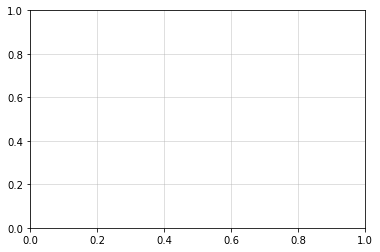

In [28]:
boot_size= 100
nboots = 1000
bp_dict = {}
ecdf_dict = {}
conv_boot = np.zeros((len(stop_cases), 3, nboots))
eps = np.finfo(float).eps
ecdf2_mat = np.zeros((len(stop_cases), len(time)))
for st in tqdm(range(len(stop_cases))):
    ecdf2_st = stop_times_df2[cols[st]].dropna()
    for T_idx in range(len(time)):
        T = time[T_idx]
        ecdf2_mat[st, T_idx] = len(np.where(ecdf2_st <= T)[0])/len(ecdf2_st)

for i in tqdm(range(nboots)):
    df_boot = stop_times_df2.iloc[np.random.choice(100000, boot_size)].dropna().reset_index().drop(columns = ["index"])
    for st in range(len(stop_cases)):
        st_df_boot = df_boot[cols[st]]
        bp_dict[i] = st_df_boot
        ecdf_boot = np.zeros(len(time))
        for T_idx in range(len(time)):
            T = time[T_idx]
            ecdf_boot[T_idx] = len(np.where(st_df_boot <= T)[0])/len(st_df_boot)
        
        conv_boot[st, 0, i] = np.max(np.abs(ecdf2_mat[st, :] - ecdf_boot))
        conv_boot[st, 1, i] = sp.stats.entropy(np.nan_to_num(ecdf2_mat[st, :]) + eps, np.nan_to_num(ecdf_boot)+ eps)
        conv_boot[st, 2, i] = SSE(ecdf2_mat[st, :], ecdf_boot)

conv_boot_lq_KS = np.quantile(conv_boot[:, 0, :], 0.05, axis = 1)
conv_boot_uq_KS = np.quantile(conv_boot[:, 0, :], 0.95, axis = 1)

conv_boot_lq_KL = np.quantile(conv_boot[:, 1, :], 0.05, axis = 1)
conv_boot_uq_KL = np.quantile(conv_boot[:, 1, :], 0.95, axis = 1)

conv_boot_lq_L2 = np.quantile(conv_boot[:, 2, :], 0.05, axis = 1)
conv_boot_uq_L2 = np.quantile(conv_boot[:, 2, :], 0.95, axis = 1)




# plt.plot(stop_cases, conv_boot_lq_KS, color="tab:grey", linestyle = '--')
# plt.plot(stop_cases, conv_boot_uq_KS, color="tab:grey", linestyle = '--')
# plt.fill_between(stop_cases.flatten(), conv_boot_lq_KS, conv_boot_uq_KS, color="tab:grey", alpha = 0.1)

# plt.plot(stop_cases[:], convergence_mat[:, 0, 0], label = "Monte Carlo", color = "tab:grey", alpha = 0.8)
# plt.plot(stop_cases[:], convergence_mat[:, 0, 1], label = r'$\chi^2$')
# plt.plot(stop_cases[:], convergence_mat[:, 0, 2], label = "Feller")
# plt.plot(stop_cases[:], convergence_mat[:, 0, 3], label = "GP")
# plt.legend()
# plt.xscale('log')
# plt.yscale('log')



/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21254/2417798963.py:47: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_ylim([0, 1e-2])
/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21254/2417798963.py:48: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1].set_ylim([0, 1])


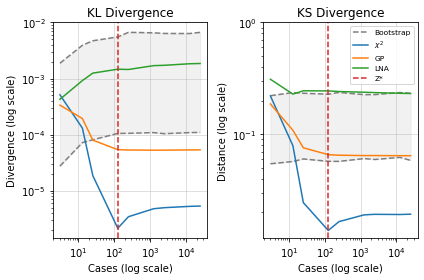

In [29]:

conv_boot_lq_KS = np.quantile(conv_boot[:, 0, :], 0.01, axis = 1).flatten()
conv_boot_uq_KS = np.quantile(conv_boot[:, 0, :], 0.99, axis = 1).flatten()

conv_boot_lq_KL = np.quantile(conv_boot[:, 1, :], 0.01, axis = 1).flatten()
conv_boot_uq_KL = np.quantile(conv_boot[:, 1, :], 0.99, axis = 1).flatten()

conv_boot_lq_L2 = np.quantile(conv_boot[:, 2, :], 0.01, axis = 1).flatten()
conv_boot_uq_L2 = np.quantile(conv_boot[:, 2, :], 0.99, axis = 1).flatten()

# plt.plot(stop_cases[:], convergence_mat[:, 0, 0], label = "Monte Carlo", color = "tab:grey", alpha = 0.8)


fig, ax = plt.subplots(1, 2)
ax[0].grid(alpha = 0.5)
ax[0].plot(stop_cases, conv_boot_lq_KL, color="tab:grey", linestyle = '--')
ax[0].plot(stop_cases, conv_boot_uq_KL, color="tab:grey", linestyle = '--')
ax[0].fill_between(stop_cases.flatten(), conv_boot_lq_KL, conv_boot_uq_KL, color="tab:grey", alpha = 0.1)
ax[0].plot(stop_cases[:], convergence_mat[:, 1 , 1], label = r'$\chi^2$')
# plt.plot(stop_cases[1:], convergence_mat[1:, 1, 2], label = "Feller")
ax[0].plot(stop_cases[:], convergence_mat[:, 1, 3], label = "GP")
ax[0].plot(stop_cases[:], convergence_mat[:, 1, 4], label = "LNA")
ax[0].axvline(Imax_feller, color = "tab:red", linestyle = '--', label = "Z*")
# ax[0].plot(stop_cases[:], convergence_mat[:, 1, 5], label = "LNA2", color = "tab:purple")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('KL Divergence')
ax[0].set_ylabel("Divergence (log scale)")
ax[0].set_xlabel("Cases (log scale)")


ax[1].grid(alpha = 0.5)
ax[1].plot(stop_cases, conv_boot_lq_KS, color="tab:grey", linestyle = '--', label = "Bootstrap")
ax[1].plot(stop_cases, conv_boot_uq_KS, color="tab:grey", linestyle = '--')
ax[1].fill_between(stop_cases.flatten(), conv_boot_lq_KS, conv_boot_uq_KS, color="tab:grey", alpha = 0.1)
ax[1].plot(stop_cases[:], convergence_mat[:, 0 , 1], label = r'$\chi^2$')
# plt.plot(stop_cases[1:], convergence_mat[1:, 1, 2], label = "Feller")
ax[1].plot(stop_cases[:], convergence_mat[:, 0, 3], label = "GP")
ax[1].plot(stop_cases[:], convergence_mat[:, 0, 4], label = "LNA")
# ax[1].plot(stop_cases[:], convergence_mat[:, 0, 5], label = "LNA2", color = "tab:purple")
ax[1].axvline(Imax_feller, color = "tab:red", linestyle = '--', label = "Z*")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('KS Divergence')
ax[1].set_ylabel("Distance (log scale)")
ax[1].set_xlabel("Cases (log scale)")
ax[1].legend(loc = 'upper right', prop={'size': 7.5})
ax[0].set_ylim([0, 1e-2])
ax[1].set_ylim([0, 1])

fig.tight_layout()
# plt.savefig("Convergence_plot_nboot=" + str(nboots) + "_R=" + str(Reff) + ".pdf")